In [1]:
import os
print(os.getcwd())

/home/jupyter-bryan/ISA_Data


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.backend import sigmoid
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Conv1D, Dense, Dropout, LayerNormalization, Bidirectional, LSTM, GRU, Layer, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Lambda, Reshape, Flatten, Input, MultiHeadAttention, Flatten, Concatenate, Add, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

2025-11-18 21:09:13.307858: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def clean_and_interpolate(data):
    df = pd.DataFrame(data).astype(np.float32)
     
    df_linear = df.interpolate(method='linear', limit_direction='both', axis=1, limit=None)
    df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)

    df_final = df_spline.fillna(0)
    
    # Clip extreme values
    df_interpolated_fin = df_final.clip(-1e6, 1e6)
    print(f"Final NaN count: {df_interpolated_fin.isnull().sum().sum()}")
    result = df_interpolated_fin.values
    
    return result

In [4]:
def prepare_multi_region_data(citarum_01_paths, citarum_02_paths, citarum_03_paths, jkt_paths):
    def load_region_data(paths):
        # Load all dataframes for a region
        ndvi_df = pd.read_csv(paths['ndvi'],delimiter=';', encoding='utf-8-sig',decimal=',')
        mndwi_df = pd.read_csv(paths['mndwi'],delimiter=';', encoding='utf-8-sig',decimal=',')
        ndbi_df = pd.read_csv(paths['ndbi'],delimiter=';', encoding='utf-8-sig',decimal=',')
        ndbsi_df = pd.read_csv(paths['ndbsi'],delimiter=';', encoding='utf-8-sig',decimal=',')
        cbi_df = pd.read_csv(paths['cbi'],delimiter=';', encoding='utf-8-sig',decimal=',')
        uci_df = pd.read_csv(paths['uci'],delimiter=';', encoding='utf-8-sig',decimal=',')
        print('NDVI shape before int:', ndvi_df.shape)
        
        # Extract features
        ndvi_features = ndvi_df.iloc[:,5:29].values
        mndwi_features = mndwi_df.iloc[:,5:29].values
        ndbi_features = ndbi_df.iloc[:,5:29].values
        ndbsi_features = ndbsi_df.iloc[:,5:29].values
        cbi_features = cbi_df.iloc[:,5:29].values
        uci_features = uci_df.iloc[:,5:29].values
        print('NDVI shape after int:', ndvi_features.shape)
        
        # Clean and interpolate
        ndvi_features = clean_and_interpolate(ndvi_features)
        mndwi_features = clean_and_interpolate(mndwi_features)
        ndbi_features = clean_and_interpolate(ndbi_features)
        ndbsi_features = clean_and_interpolate(ndbsi_features)
        cbi_features = clean_and_interpolate(cbi_features)
        uci_features = clean_and_interpolate(uci_features)
        
        # Combine features
        X = np.concatenate([ndvi_features, mndwi_features, ndbi_features, 
                            ndbsi_features, cbi_features, uci_features], axis=1)
        
        # Reshape
        X = X.reshape(X.shape[0], 24, 6) 
        
        # Get labels, slope and elev
        labels = ndvi_df.iloc[:, 1].values
        slope_values = ndvi_df.iloc[:,29].values
        elev_values = ndvi_df.iloc[:,30].values
        
        # return X, labels, slope_values
        return X, labels, slope_values, elev_values

    # Load data for both regions
    X_citarum_01, labels_citarum_01, slope_citarum_01, elev_citarum_01 = load_region_data(citarum_01_paths)
    X_citarum_02, labels_citarum_02, slope_citarum_02, elev_citarum_02 = load_region_data(citarum_02_paths)
    X_citarum_03, labels_citarum_03, slope_citarum_03, elev_citarum_03 = load_region_data(citarum_03_paths)
    X_jkt, labels_jkt, slope_jkt, elev_jkt = load_region_data(jkt_paths)
    
    # Combine data from both regions
    X_combined = np.concatenate([X_citarum_01, X_citarum_02, X_citarum_03, X_jkt], axis=0)
    labels_combined = np.concatenate([labels_citarum_01, labels_citarum_02, labels_citarum_03, labels_jkt])
    slope_combined = np.concatenate([slope_citarum_01, slope_citarum_02, slope_citarum_03, slope_jkt])
    elev_combined = np.concatenate([elev_citarum_01, elev_citarum_02, elev_citarum_03, elev_jkt])
    
    # Compute class weights on combined data
    unique_classes = np.unique(labels_combined)

    print("Labels combined shape:", labels_combined.shape)
    print("Labels combined type:", type(labels_combined[0]) if len(labels_combined) > 0 else "Empty")
    print("Unique classes from np.unique:", unique_classes)
    print("Unique classes type:", type(unique_classes[0]) if len(unique_classes) > 0 else "Empty")
    print("All unique values in labels_combined:", set(labels_combined))
    print("Any NaN values?", np.any(pd.isna(labels_combined)))

    # Check if there are any labels in y that aren't in classes
    missing_labels = set(labels_combined) - set(unique_classes)
    print("Labels in y but not in classes:", missing_labels)
    
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=unique_classes,
        y=labels_combined)
    
    class_weight_dict = dict(enumerate(class_weights))
    print("Class weights:", class_weight_dict)
    
    y = np.asarray(labels_combined)
    print(y)
    print(len(np.unique(y)))
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_combined = label_encoder.fit_transform(labels_combined)
    y_combined = to_categorical(y_combined)
    print(y_combined)
    
    # Split combined data
    X_train, X_test, y_train, y_test, slope_train, slope_test, elev_train, elev_test = train_test_split(X_combined, y_combined, 
                                                                                                        slope_combined, elev_combined,
                                                                                                        test_size=0.3,random_state=42,
                                                                                                        stratify=y_combined)
    
    # Convert slope values to tensorflow constant
    slope_train = tf.constant(slope_train, dtype=tf.float32)
    slope_test = tf.constant(slope_test, dtype=tf.float32)

    # Convert elev values to tensorflow constant
    elev_train = tf.constant(elev_train, dtype=tf.float32)
    elev_test = tf.constant(elev_test, dtype=tf.float32)
    
    return (X_train, X_test, y_train, y_test, label_encoder, class_weight_dict, slope_train, slope_test, elev_train, elev_test, y)

In [5]:
citarum_01_paths = {
    'ndvi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_NDVI_ROI_01.csv',
    'mndwi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_MNDWI_ROI_01.csv',
    'ndbi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_NDBI_ROI_01.csv',
    'ndbsi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_NDBSI_ROI_01.csv',
    'cbi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_CBI_ROI_01.csv',
    'uci': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_UCI_ROI_01.csv'
}

citarum_02_paths = {
    'ndvi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_NDVI_ROI_02.csv',
    'mndwi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_MNDWI_ROI_02.csv',
    'ndbi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_NDBI_ROI_02.csv',
    'ndbsi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_NDBSI_ROI_02.csv',
    'cbi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_CBI_ROI_02.csv',
    'uci': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_UCI_ROI_02.csv'
}

citarum_03_paths = {
    'ndvi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_NDVI_ROI_03.csv',
    'mndwi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_MNDWI_ROI_03.csv',
    'ndbi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_NDBI_ROI_03.csv',
    'ndbsi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_NDBSI_ROI_03.csv',
    'cbi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_CBI_ROI_03.csv',
    'uci': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_Citarum_UCI_ROI_03.csv'
}

jkt_paths = {
    'ndvi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_DKI_NDVI.csv',
    'mndwi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_DKI_MNDWI.csv',
    'ndbi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_DKI_NDBI.csv',
    'ndbsi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_DKI_NDBSI.csv',
    'cbi': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_DKI_CBI.csv',
    'uci': '/home/jupyter-bryan/ISA_Data/Sample_Points_ISA_DKI_UCI.csv'
}

# Prepare the combined data
X_train, X_test, y_train, y_test, label_encoder, class_weight_dict, slope_train, slope_test, elev_train, elev_test, y = prepare_multi_region_data(citarum_01_paths, 
                                                                                                                                                      citarum_02_paths, 
                                                                                                                                                      citarum_03_paths,
                                                                                                                                                      jkt_paths)

NDVI shape before int: (2473, 31)
NDVI shape after int: (2473, 24)
Final NaN count: 0


/tmp/ipykernel_530023/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_530023/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)


Final NaN count: 0
Final NaN count: 0


/tmp/ipykernel_530023/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_530023/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)


Final NaN count: 0
Final NaN count: 0


/tmp/ipykernel_530023/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_530023/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)


Final NaN count: 0
NDVI shape before int: (1972, 31)
NDVI shape after int: (1972, 24)
Final NaN count: 0


/tmp/ipykernel_530023/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_530023/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_530023/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)


Final NaN count: 0
Final NaN count: 0
Final NaN count: 0


/tmp/ipykernel_530023/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_530023/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_530023/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_530023/1661099113.py:5: FutureWarning: DataFrame.fillna with 'me

Final NaN count: 0
Final NaN count: 0
NDVI shape before int: (533, 31)
NDVI shape after int: (533, 24)
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0
Final NaN count: 0


/tmp/ipykernel_530023/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_530023/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_530023/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_530023/1661099113.py:5: FutureWarning: DataFrame.fillna with 'me

NDVI shape before int: (2205, 31)
NDVI shape after int: (2205, 24)
Final NaN count: 0


/tmp/ipykernel_530023/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_530023/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_530023/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)


Final NaN count: 0
Final NaN count: 0
Final NaN count: 0


/tmp/ipykernel_530023/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_530023/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
/tmp/ipykernel_530023/1661099113.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spline = df_linear.interpolate(method='spline', order=3, axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)


Final NaN count: 0
Final NaN count: 0
Labels combined shape: (7183,)
Labels combined type: <class 'numpy.int64'>
Unique classes from np.unique: [1 2 3 4 5]
Unique classes type: <class 'numpy.int64'>
All unique values in labels_combined: {np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)}
Any NaN values? False
Labels in y but not in classes: set()
Class weights: {0: np.float64(0.4424391746227287), 1: np.float64(0.8934079601990049), 2: np.float64(0.9115482233502538), 3: np.float64(3.1435448577680525), 4: np.float64(4.8698305084745765)}
[1 1 1 ... 2 2 2]
5
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


I0000 00:00:1763471358.111240  530023 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7828 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


In [6]:
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

tf.keras.utils.get_custom_objects().update({'swish': swish})

def ReshapeLayer(x):
    shape = x.shape
    # 1 possibility: H,W*channel
    reshape = Reshape((shape[1],shape[2]))(x)
    # 2 possibility: W,H*channel
    # transpose = Permute((2,1,3))(x)
    # reshape = Reshape((shape[1],shape[2]*shape[3]))(transpose)
    return reshape

In [7]:
n_classes=len(label_encoder.classes_)

def make_model(n_classes, n_timesteps=24, n_features=6):
    input_layer = Input(shape=(n_timesteps, n_features))
    
    x = Conv1D(32, 1, activation="relu")(input_layer)
    x = Conv1D(64, 3, activation="relu")(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(64, 1, activation="relu")(x)
    x = Conv1D(128, 3, activation="relu")(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Flatten()(x)
    x = Dense(200, activation="relu")(x)
    x = Dense(50, activation="relu")(x)
    output_layer = Dense(n_classes, activation="softmax")(x)
    
    return Model(inputs=input_layer, outputs=output_layer)

model = make_model(n_classes=len(label_encoder.classes_))
model.summary()

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=Adam(learning_rate=0.001), 
              metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath='/home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig_Deep1DCNN.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             mode='max')

early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=100,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.1,
                              patience=30, 
                              min_lr=0.00001)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    batch_size =20,
                    epochs=500,
                    callbacks = [checkpoint, early_stop, reduce_lr], 
                    class_weight = class_weight_dict)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 24, 6)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 24, 32)         │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 22, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 11, 64)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 9, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 200)            │       102,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │        10,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,201 (578.91 KB)

 Trainable params: 148,201 (578.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500


2025-11-18 21:09:20.383164: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f7be8005ba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-18 21:09:20.383181: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-11-18 21:09:20.421727: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-18 21:09:20.695197: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-11-18 21:09:20.742772: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-18 21:09:20.742810: I e

 77/252 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6420 - loss: 1.0953

I0000 00:00:1763471367.757136  530562 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7513 - loss: 0.7543
Epoch 1: val_accuracy improved from None to 0.87796, saving model to /home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig_Deep1DCNN.h5


252/252 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.8250 - loss: 0.5209 - val_accuracy: 0.8780 - val_loss: 0.3539 - learning_rate: 0.0010
Epoch 2/500
248/252 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8645 - loss: 0.3805
Epoch 2: val_accuracy improved from 0.87796 to 0.88445, saving model to /home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig_Deep1DCNN.h5


252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8709 - loss: 0.3566 - val_accuracy: 0.8845 - val_loss: 0.3299 - learning_rate: 0.0010
Epoch 3/500
247/252 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8896 - loss: 0.2987
Epoch 3: val_accuracy improved from 0.88445 to 0.90162, saving model to /home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig_Deep1DCNN.h5


252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8874 - loss: 0.3046 - val_accuracy: 0.9016 - val_loss: 0.2848 - learning_rate: 0.0010
Epoch 4/500
248/252 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9045 - loss: 0.2488
Epoch 4: val_accuracy improved from 0.90162 to 0.90812, saving model to /home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig_Deep1DCNN.h5


252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9025 - loss: 0.2575 - val_accuracy: 0.9081 - val_loss: 0.2718 - learning_rate: 0.0010
Epoch 5/500
238/252 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9076 - loss: 0.2418
Epoch 5: val_accuracy improved from 0.90812 to 0.91323, saving model to /home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig_Deep1DCNN.h5


252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9129 - loss: 0.2274 - val_accuracy: 0.9132 - val_loss: 0.2468 - learning_rate: 0.0010
Epoch 6/500
241/252 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9255 - loss: 0.1803
Epoch 6: val_accuracy improved from 0.91323 to 0.92019, saving model to /home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig_Deep1DCNN.h5


252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9238 - loss: 0.1947 - val_accuracy: 0.9202 - val_loss: 0.2438 - learning_rate: 0.0010
Epoch 7/500
251/252 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9301 - loss: 0.1680
Epoch 7: val_accuracy did not improve from 0.92019
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9306 - loss: 0.1764 - val_accuracy: 0.9132 - val_loss: 0.2506 - learning_rate: 0.0010
Epoch 8/500
251/252 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9493 - loss: 0.1296
Epoch 8: val_accuracy improved from 0.92019 to 0.93132, saving model to /home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig_Deep1DCNN.h5


252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9387 - loss: 0.1543 - val_accuracy: 0.9313 - val_loss: 0.2113 - learning_rate: 0.0010
Epoch 9/500
241/252 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9467 - loss: 0.1322
Epoch 9: val_accuracy did not improve from 0.93132
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9403 - loss: 0.1376 - val_accuracy: 0.9262 - val_loss: 0.2360 - learning_rate: 0.0010
Epoch 10/500
246/252 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9418 - loss: 0.1443
Epoch 10: val_accuracy did not improve from 0.93132
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9397 - loss: 0.1469 - val_accuracy: 0.9202 - val_loss: 0.2443 - learning_rate: 0.0010
Epoch 11/500
246/252 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9346 - loss: 0.1577
Epoch 11: val_accuracy did not improve from 0.93132
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9457 - loss: 0.1304 - val_accuracy: 0.9230 - val_loss: 0.2631 - learning_rate: 0.0010
Epoch 12/500
240/2

252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9704 - loss: 0.0734 - val_accuracy: 0.9332 - val_loss: 0.2679 - learning_rate: 0.0010
Epoch 18/500
244/252 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9605 - loss: 0.1283
Epoch 18: val_accuracy improved from 0.93318 to 0.93968, saving model to /home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig_Deep1DCNN.h5


252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9672 - loss: 0.0922 - val_accuracy: 0.9397 - val_loss: 0.2419 - learning_rate: 0.0010
Epoch 19/500
244/252 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9767 - loss: 0.0610
Epoch 19: val_accuracy did not improve from 0.93968
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9761 - loss: 0.0574 - val_accuracy: 0.9374 - val_loss: 0.2661 - learning_rate: 0.0010
Epoch 20/500
233/252 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9701 - loss: 0.0811
Epoch 20: val_accuracy did not improve from 0.93968
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9606 - loss: 0.1050 - val_accuracy: 0.9346 - val_loss: 0.2500 - learning_rate: 0.0010
Epoch 21/500
247/252 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9738 - loss: 0.0623
Epoch 21: val_accuracy did not improve from 0.93968
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9767 - loss: 0.0611 - val_accuracy: 0.9350 - val_loss: 0.2767 - learning_rate: 0.0010
Epoch 22/500
244

252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9805 - loss: 0.0473 - val_accuracy: 0.9429 - val_loss: 0.2385 - learning_rate: 0.0010
Epoch 23/500
248/252 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9893 - loss: 0.0307
Epoch 23: val_accuracy improved from 0.94292 to 0.94339, saving model to /home/jupyter-bryan/ISA_Data/ISA_Citarum_Multi_Orig_Deep1DCNN.h5


252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9845 - loss: 0.0419 - val_accuracy: 0.9434 - val_loss: 0.2925 - learning_rate: 0.0010
Epoch 24/500
232/252 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9678 - loss: 0.0750
Epoch 24: val_accuracy did not improve from 0.94339
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9686 - loss: 0.0765 - val_accuracy: 0.9364 - val_loss: 0.2628 - learning_rate: 0.0010
Epoch 25/500
244/252 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9785 - loss: 0.0662
Epoch 25: val_accuracy did not improve from 0.94339
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9765 - loss: 0.0651 - val_accuracy: 0.9197 - val_loss: 0.3573 - learning_rate: 0.0010
Epoch 26/500
244/252 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9791 - loss: 0.0471
Epoch 26: val_accuracy did not improve from 0.94339
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9845 - loss: 0.0387 - val_accuracy: 0.9397 - val_loss: 0.3131 - learning_rate: 0.0010
Epoch 27/500
245

252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9922 - loss: 0.0178 - val_accuracy: 0.9448 - val_loss: 0.3712 - learning_rate: 0.0010
Epoch 38/500
248/252 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9615 - loss: 0.1165
Epoch 38: val_accuracy did not improve from 0.94478
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9642 - loss: 0.1063 - val_accuracy: 0.9360 - val_loss: 0.2520 - learning_rate: 0.0010
Epoch 39/500
250/252 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9892 - loss: 0.0236
Epoch 39: val_accuracy did not improve from 0.94478
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9901 - loss: 0.0224 - val_accuracy: 0.9360 - val_loss: 0.3374 - learning_rate: 0.0010
Epoch 40/500
249/252 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9861 - loss: 0.0287
Epoch 40: val_accuracy did not improve from 0.94478
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9813 - loss: 0.0424 - val_accuracy: 0.9392 - val_loss: 0.3115 - learning_rate: 0.0010
Epoch 41/500
244

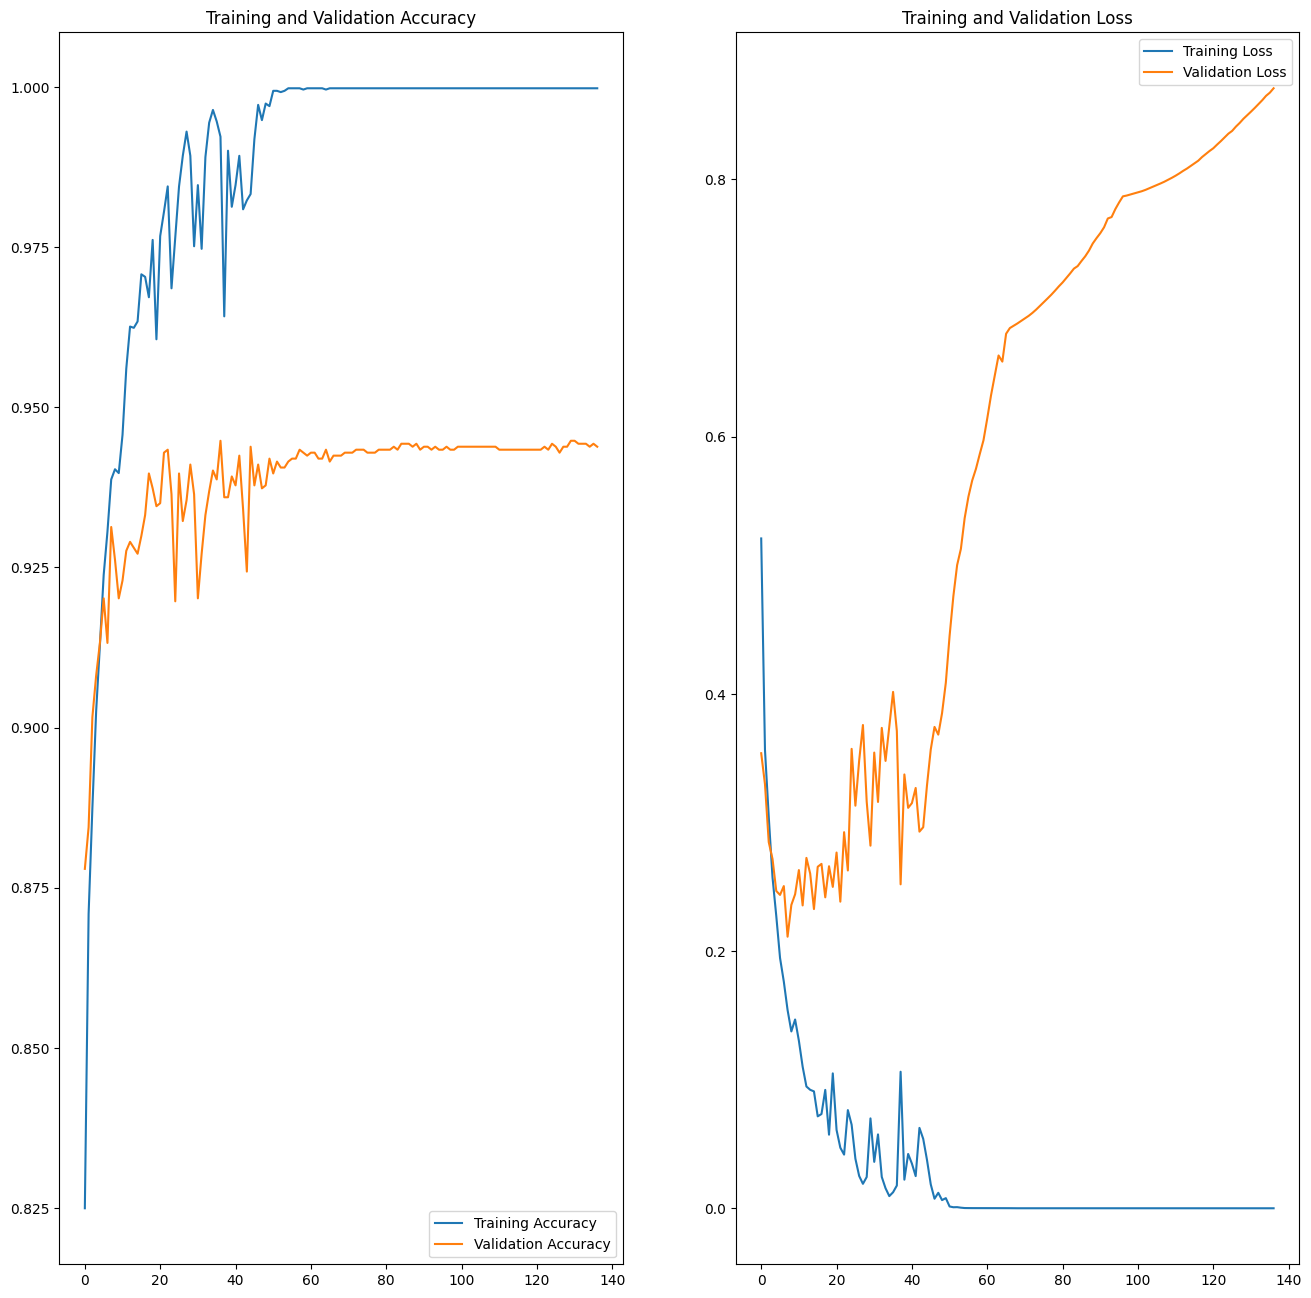

In [8]:
n_epochs = len(history.history['loss'])

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(n_epochs) #change it based on epoch needed to finish building the model

plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

2025-11-18 21:11:10.691713: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-18 21:11:10.691743: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-18 21:11:11.281075: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_86', 4 bytes spill stores, 4 bytes spill loads

2025-11-18 21:11:12.049379: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Reg

68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step


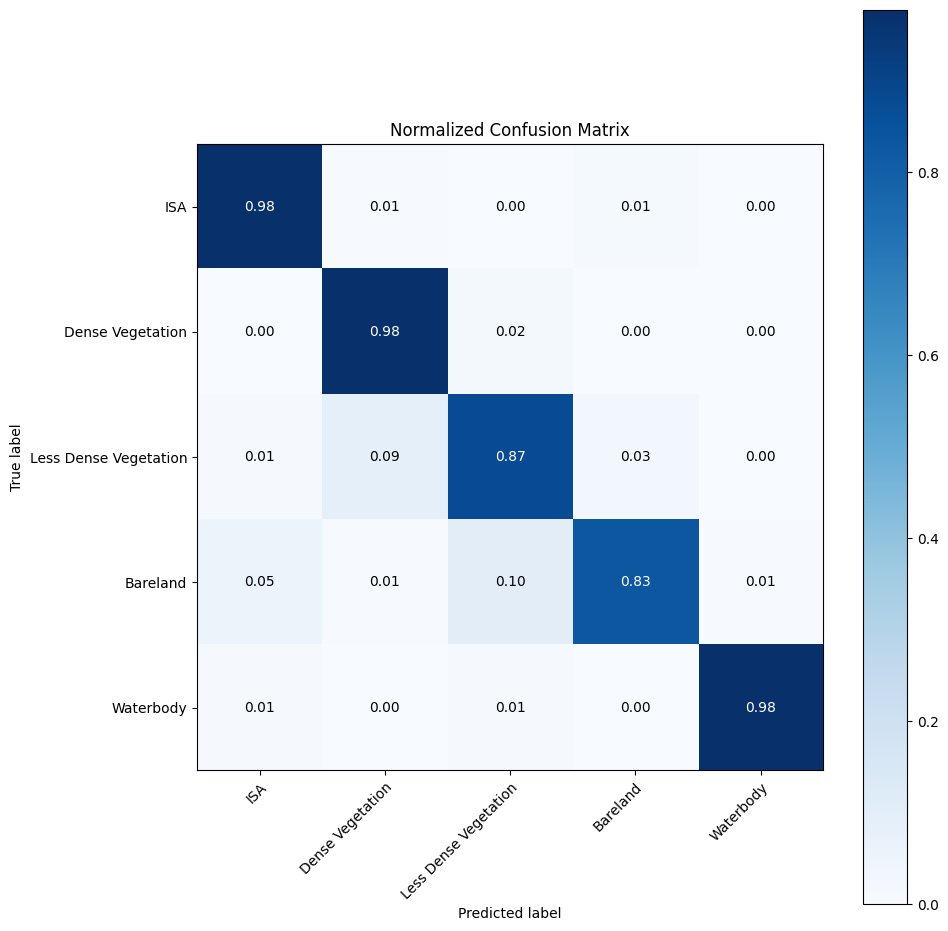

In [9]:
#confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

classes = ['ISA','Dense Vegetation','Less Dense Vegetation', 'Bareland', 'Waterbody']

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
score = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

dl_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(dl_cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(dl_cm.shape[1]),
        yticks=np.arange(dl_cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes, yticklabels=classes,
        title='Normalized Confusion Matrix',
        ylabel='True label',
        xlabel='Predicted label')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
          rotation_mode="anchor")

fmt = '.2f'
thresh = dl_cm.max() / 2.
for i in range(dl_cm.shape[0]):
    for j in range(dl_cm.shape[1]):
        ax.text(j, i, format(dl_cm[i, j], fmt),
                ha="center", va="center",
                color="white" if dl_cm[i, j] > thresh else "black")
fig.tight_layout()